## overview

In [1]:
# default package
import logging
import sys 
import os
import pathlib
import IPython
import random
from urllib.request import urlretrieve
import dataclasses as dc
import tempfile

In [2]:
# third party package
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import seaborn as sns
import yaml
from mlflow.tracking import MlflowClient
from matplotlib.font_manager import FontProperties
import matplotlib
# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

In [3]:
# my package
sys.path.append(os.path.join(pathlib.Path().resolve(),"../"))
import src.model.dcgan as dcgan
import src.dataset.generate_pathlist as gp
import src.dataset.image_dataset as dataset
import src.model.image_generate as ig

In [4]:
# reload settings
%load_ext autoreload
%autoreload 2

In [5]:
# logger
logger=logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [6]:
# graph setting
sns.set()
font_path = "/usr/share/fonts/truetype/migmix/migmix-1p-regular.ttf"
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams["font.family"] = font_prop.get_name()

In [7]:
# gpu
torch.cuda.is_available()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# chdir
current_dir=pathlib.Path().resolve()
if current_dir.stem=="notebooks":
    os.chdir(current_dir.parent)
logger.info(pathlib.Path().resolve())

INFO:__main__:/workspaces/load_to_goal/GitHub/pytorch-implementation/gan_based_anomaly_detection


## load model

In [9]:
# mlflow global parameter
experiment_name="experiment"
run_id="8c811f0dd3a5400f8bc3aa08c405e889"
tracking_uri="logs/mlruns"

In [10]:
def load_model():
    client = MlflowClient(tracking_uri=tracking_uri)
    with tempfile.TemporaryDirectory() as dname:
        config_path=client.download_artifacts(run_id,"config.yml",dname)
        with open(config_path) as f:
            config=yaml.load(f,Loader=yaml.SafeLoader)
            
        model_path=[artifact.path for artifact 
                    in client.list_artifacts(run_id)
                    if "pth" in artifact.path][0]
        model_path=client.download_artifacts(run_id,model_path,dname)
        model = ig.GAN(
            discriminator=dcgan.Discriminator(),
            generator=dcgan.Generator(),
            criterion=nn.BCEWithLogitsLoss(reduction="mean"),
            **config,
        )
        model.load_state_dict(torch.load(model_path))
        model=model.to(device)
        model.eval()
        
    return model

In [11]:
model=load_model()

## load test data

In [12]:
# data global parameter
test_dir="./data/test"
batch_size=2

In [13]:
path_list=gp.make_datapath_list(test_dir)
test_dataset=dataset.ImageDataset(path_list,dataset.BaseTransform())
test_loader=DataLoader(test_dataset,batch_size=batch_size,shuffle=False,drop_last=True)

In [14]:
for batch in test_loader:
    imgs=batch

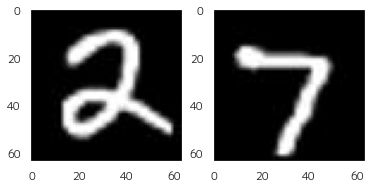

In [15]:
fig,axes=plt.subplots(1,batch_size,squeeze=False)
for i in range(batch_size):
    axes[0,i].imshow(imgs[i].permute(1,2,0),cmap="gray")
    axes[0,i].grid(False)

In [16]:
imgs=imgs.to(device)

## AnoGAN

In [17]:
# anogan global paramter
max_epochs=2000
lr=1e-3
lambda_=0.1

In [18]:
def Anomaly_score(x, fake_img, D, Lambda=0.1):
    """
    - residual_loss(テスト画像xと生成画像fake_imgのピクセルレベルの差の絶対値)
    - discrimination_loss(テスト画像xと生成画像fake_imgの特徴量の差の絶対値)
    """

    residual_loss = torch.abs(x-fake_img)
    residual_loss = residual_loss.view(residual_loss.size()[0], -1)
    residual_loss = torch.sum(residual_loss, dim=1)

    _, x_feature = D(x)
    _, G_feature = D(fake_img)
    discrimination_loss = torch.abs(x_feature-G_feature)
    discrimination_loss = discrimination_loss.view(
        discrimination_loss.size()[0], -1)
    discrimination_loss = torch.sum(discrimination_loss, dim=1)

    loss_each = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    total_loss = torch.sum(loss_each)

    return total_loss, loss_each, residual_loss

In [19]:
z=torch.randn(batch_size,20,1,1).to(device)
z.requires_grad=True
optimizer=optim.Adam([z],lr=lr)

In [20]:
for epoch in tqdm(range(max_epochs)):
    fake_img=model.generator(z)
    loss, _, _ = Anomaly_score(imgs, fake_img, model.discriminator, Lambda=0.1)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%1000==0: print(loss)

  0%|          | 4/2000 [00:00<02:12, 15.12it/s]

tensor(2876.8594, device='cuda:0', grad_fn=<SumBackward0>)


 50%|█████     | 1006/2000 [00:41<00:34, 28.55it/s]

tensor(1546.1587, device='cuda:0', grad_fn=<SumBackward0>)


100%|██████████| 2000/2000 [01:21<00:00, 24.43it/s]


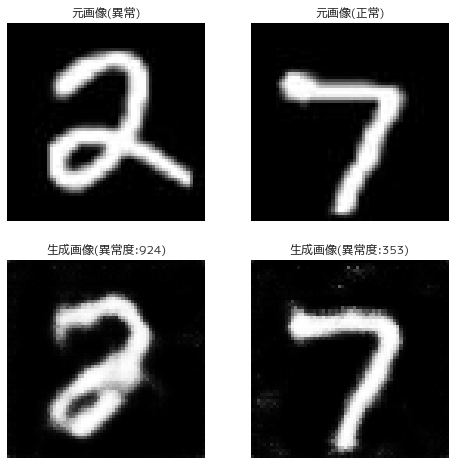

In [21]:
model.generator.eval()
fake_img = model.generator(z)

_, loss_each, _= Anomaly_score(
    imgs, fake_img, model.discriminator, Lambda=lambda_)
loss_each = loss_each.cpu().detach().numpy()

fig,axes=plt.subplots(2,batch_size,squeeze=False,figsize=(8,8))
for i in range(batch_size):
    axes[0,i].imshow(imgs[i].cpu().detach().permute(1,2,0),cmap="gray")
    axes[1,i].imshow(fake_img[i].cpu().detach().permute(1,2,0),cmap="gray")
    axes[1,i].set_title(f"生成画像(異常度:{int(loss_each[i])})")
    axes[0,i].grid(False)
    axes[1,i].grid(False)
    axes[0,i].axis("off")
    axes[1,i].axis("off")
axes[0,0].set_title("元画像(異常)")
axes[0,1].set_title("元画像(正常)");